<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1><h1>Pre-trained-Models with PyTorch </h1>

In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>

<h2 id="download_data">Download Data</h2>

Download of data and unzipping the data files has done already on my local machine.Now we will verify the data

In [1]:
import os
import torch
current_directory_path = os.getcwd()

# Path in local machine
data_path = current_directory_path + "/Data/"

#checking folders in data_path
os.listdir(data_path)

['Negative_tensors', 'Positive_tensors']

In [2]:
#Setting path for positive and negative images
positive_images= current_directory_path + "/Data/Positive_tensors"
negative_images= current_directory_path + "/Data/Negative_tensors"

In [3]:
#Checking number of positive images
print("Positive images: "+str(len(os.listdir(positive_images))))

Positive images: 20000


In [4]:
#Checking number of negative images
print("Negative images: "+str(len(os.listdir(positive_images))))

Negative images: 20000


We will install torchvision:

In [5]:
#!pip install torchvision

In [6]:
#setting device to local gpu
device=torch.device("cuda")
device

device(type='cuda')

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [7]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [8]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->

<h2 id="data_class">Dataset Class</h2>

 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.

In [9]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):
        directory = data_path 
        positive = "Positive_tensors"
        negative = "Negative_tensors"

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        
        number_of_samples = len(positive_files)+len(negative_files)
        
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 
        
        # The transform is goint to be used on image
        self.transform = transform
        
        #torch.LongTensor
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):               
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [10]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [11]:
#Number of training samples
len(train_dataset)

30000

In [12]:
#Number of Validation samples
len(validation_dataset)

10000

<h2 id="Question_1">Question 1</h2>

<b>Prepare a pre-trained resnet18 model :</b>

<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [13]:
# Step 1: Load the pre-trained model resnet18
import torchvision.models as models
model = models.resnet18(pretrained=True)

In [14]:
#pass resnet18 to gpu device
model = model.to(device)


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [15]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [16]:
#replaced output layer
d_h = 512
d_out = 2
model.fc = nn.Linear(d_h, d_out) 

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>

In this question you will train your, model:

<b>Step 1</b>: Create a cross entropy criterion function 

In [18]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [19]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [20]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**

In [21]:
n_epochs = 1
loss_list = []
accuracy_list = []
accuracy = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()



running_loss = 0
start_time = time.time()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):        
        print('#' * 25)
        print('Iteration (train phase) {}/{}'.format(i+1, int(N_train/batch_size)))
        i_start_time = time.time()
        
        x=x.cuda()
        y=y.cuda()
        
        x = x.to(device)
        y = y.to(device)
        
        model.cuda()
        # set model to train 
        model.train() 
        model
        # clear gradient 
        optimizer.zero_grad()
     
        # make a prediction 
        prediction = model(x)
   
        # calculate loss 
        loss = criterion(prediction, y) 
        # loss.requires_grad = True
    
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
        
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        print('#' * 25)
        print('Iteration (validatio phase) {}/{}'.format(i+1, int(N_train/batch_size)))
        i_start_time = time.time()
        
        x_test= x_test.cuda()
        y_test=y_test.cuda()
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        model.cuda()
        # set model to eval 
        model.eval()
       
        # make a prediction 
        prediction = model(x_test)
        
        # find max 
        _, yhat = torch.max(prediction.data, 1)
       
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat==y_test).sum().item()  
        print("Finished in {} (s)".format(time.time()-i_start_time))
        
    
    accuracy=correct/N_test
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    
    accuracy_list.append(accuracy)
    print("#" * 30)
    
    print("Finished epoch {} in {} (s).".format(epoch+1, time.time()-start_time))



#########################
Iteration (train phase) 1/300
Finished in 4.895717620849609 (s)
#########################
Iteration (train phase) 2/300
Finished in 0.07124638557434082 (s)
#########################
Iteration (train phase) 3/300
Finished in 0.07222390174865723 (s)
#########################
Iteration (train phase) 4/300
Finished in 0.07124829292297363 (s)
#########################
Iteration (train phase) 5/300
Finished in 0.0780801773071289 (s)
#########################
Iteration (train phase) 6/300
Finished in 0.07808041572570801 (s)
#########################
Iteration (train phase) 7/300
Finished in 0.0780797004699707 (s)
#########################
Iteration (train phase) 8/300
Finished in 0.07711267471313477 (s)
#########################
Iteration (train phase) 9/300
Finished in 0.07808041572570801 (s)
#########################
Iteration (train phase) 10/300
Finished in 0.07515287399291992 (s)
#########################
Iteration (train phase) 11/300
Finished in 0.082960844039

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>

In [22]:
accuracy

0.9943

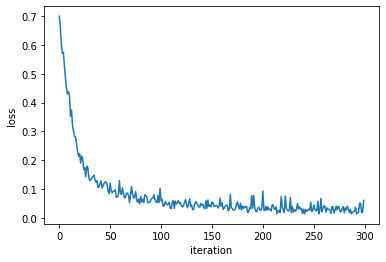

In [23]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 

<b>Identify the first four misclassified samples using the validation data:</b>

In [26]:
count = 0
max_num_of_items = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    
    x_test=x_test.cuda()
    # set model to eval
    model.cuda()
    model.eval()
    
    # make a prediction
    prediction = model(x_test)
    
    # find max
    _, yhat = torch.max(prediction.data, 1)
    
    # print mis-classified samples
    if yhat != y_test.cuda():
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= max_num_of_items:
            break
 

Sample : 22; Expected Label: tensor([1]); Obtained Label: tensor([0], device='cuda:0')
Sample : 101; Expected Label: tensor([0]); Obtained Label: tensor([1], device='cuda:0')
Sample : 182; Expected Label: tensor([1]); Obtained Label: tensor([0], device='cuda:0')
Sample : 213; Expected Label: tensor([0]); Obtained Label: tensor([1], device='cuda:0')


<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.